In [1]:
import pandas as pd

In [2]:
# Import Python Libraries
import sys
import altair as alt
import pandas as pd
import numpy as np
import calendar
# print (pd.__version__)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
alt.data_transformers.disable_max_rows()
%matplotlib inline

In [3]:
!ls data/msmarco/full_collection/

raw.tsv


In [4]:
x = pd.read_csv("data/msmarco/full_collection/raw.tsv",sep='\t', header=None, index_col = 0)

In [5]:
x.head()

,1
0,
0,The presence of communication amid scientific ...
1,The Manhattan Project and its atomic bomb help...
2,Essay on The Manhattan Project - The Manhattan...
3,The Manhattan Project was the name for a proje...
4,versions of each volume as well as complementa...


In [6]:
x.shape

(8841823, 1)

In [7]:
x_queries = pd.read_csv("data/msmarco/train_queries/queries/raw.tsv",sep='\t', header=None, index_col = 0)

In [8]:
x_queries.head()

,1
0,
121352,define extreme
634306,what does chattel mean on credit history
920825,what was the great leap forward brainly
510633,tattoo fixers how much does it cost
737889,what is decentralization process.


In [9]:
x_queries.shape

(808731, 1)

In [10]:
x_queries.loc[920825]

1    what was the great leap forward brainly
Name: 920825, dtype: object

In [11]:
display(x_queries.loc[287144,1])
display(x.loc[85742,1])

'how many kilojoules per day teenager'

'How many kilojoules should an 18 year old girl have each day? You should be safe with around 8000-9000 kilojoules per day but it is highly relative to you personally and factors such as height, activity, age, gender and weight are inclus … ive in calculating how many kilojoules you should have.'

In [12]:
display(x_queries.loc[287145,1])
display(x.loc[6849904,1])

'how many kiloliters are in a liter'

'Chemistry question: How many kiloliters is in a liter? 1 liter = 0.001 kiloliters and 1 kiloliter = 1000 liter. 55L =0.055 kiloliters 0 12 months ago Metric units are easy, kilo means 1000, and Liter is a base unit for volume.'

In [13]:
display(x_queries.loc[287140,1])
display(x.loc[5332427,1])

'how many kilograms per pound?'

'Confidence votes 7.7K. 1 pound is 0.453592 kilograms. On earth, one kilogram of mass weighs about 2.205 pounds (rounded), and 0.4536 kilogram (rounded) weighs one pound. Karl Creighton.'

In [14]:
display(x_queries.loc[287141,1])
display(x.loc[4531496,1])

'how many kilohertz in a megahertz'

'One megahertz (abbreviated: MHz) is equal to 1,000 kilohertz, or 1,000,000 hertz. It can also be described as one million cycles per second. Megahertz is used to measure wave frequencies, as well as the speed of microprocessors. Radio waves, which are used for both radio and TV broadcasts, are typically measured in megahertz.'

In [15]:
display(x_queries.loc[1057505,1])
display(x.loc[3958822,1])
display(x.loc[3958823,1])

'who were the maccabees'

'For other uses, see Maccabees (disambiguation). The Maccabees, also spelled Machabees (Hebrew: מכבים or מקבים\u200e\u200e, Maqabim; Latin: Machabaei or Maccabaei; Greek: μακκαβαῖοι, Makkabaioi), were the leaders of a Jewish rebel army that took control of Judea, which at the time had been a province of the Seleucid Empire.'

'The descendants of Mattathias. The Maccabees, also spelled Machabees (Hebrew: מכבים or מקבים\u200e\u200e, Maqabim; Latin: Machabaei or Maccabaei; Greek: μακκαβαῖοι, Makkabaioi), were the leaders of a Jewish rebel army that took control of Judea, which at the time had been a province of the Seleucid Empire.'

In [16]:
words_corp = x.sample(n=1000000)[1].apply(lambda wrd: len(wrd.split()))

In [17]:
words_corp.max()

234

In [18]:
words_corp.min()

1

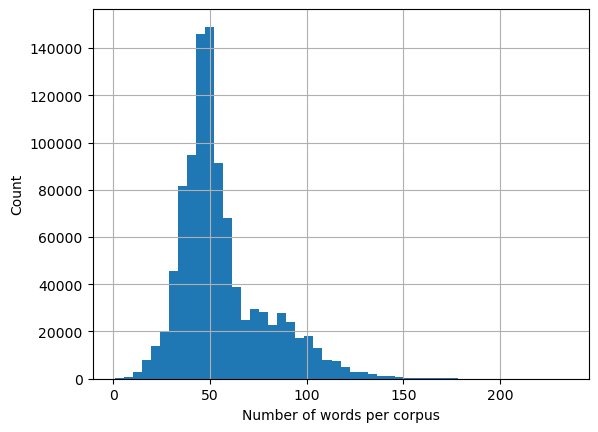

In [19]:
plt.hist(words_corp, bins=50)
plt.xlabel('Number of words per corpus')
plt.ylabel('Count')
plt.grid(b=True)

((array([-4.82696512, -4.64718223, -4.54998406, ...,  4.54998406,
          4.64718223,  4.82696512]),
  array([  1,   1,   1, ..., 229, 231, 234])),
 (21.56268345519621, 56.254847999999996, 0.9513749903065031))

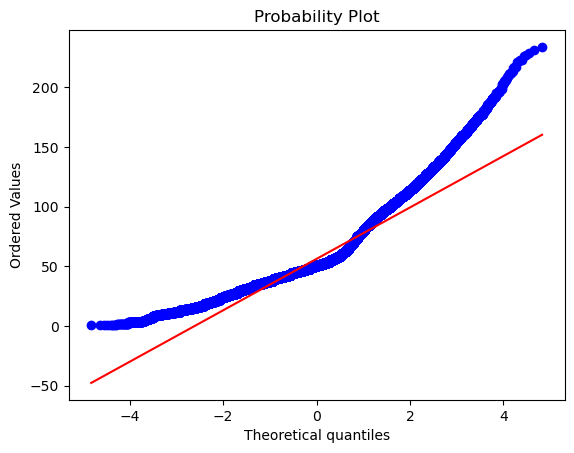

In [20]:
# Check the distribution normality
stats.probplot(words_corp, plot=plt)

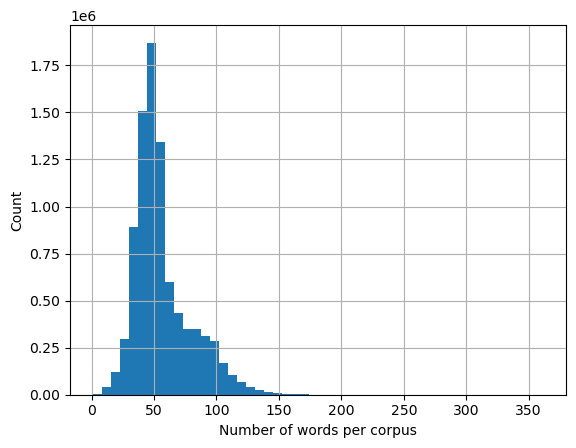

In [21]:
plt.hist(x[1].apply(lambda wrd: len(wrd.split())), bins=50)
plt.xlabel('Number of words per corpus')
plt.ylabel('Count')
plt.grid(b=True)

In [22]:
uniq_words = x[:1000000][1].apply(lambda wrd: len(set(str(wrd).split())))
uniq_words

0
0         38
1         27
2         32
3         39
4         30
          ..
999995    51
999996    40
999997    44
999998    58
999999    54
Name: 1, Length: 1000000, dtype: int64

Text(0, 0.5, 'Count')

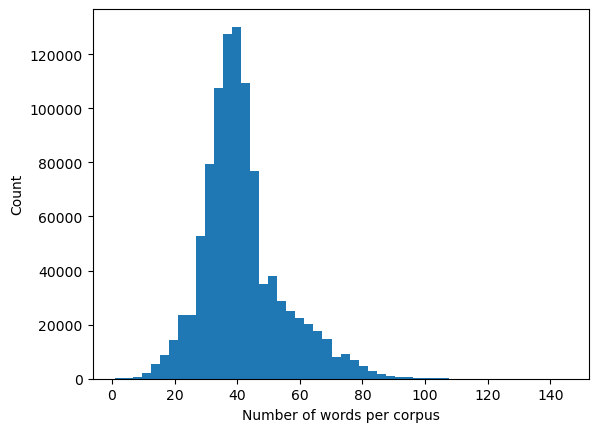

In [23]:
plt.hist(uniq_words, bins=50)
plt.xlabel('Number of words per corpus')
plt.ylabel('Count')

((array([-4.82696512, -4.64718223, -4.54998406, ...,  4.54998406,
          4.64718223,  4.82696512]),
  array([  1,   1,   1, ..., 134, 144, 145])),
 (12.540956571422742, 41.693698, 0.9738140890186551))

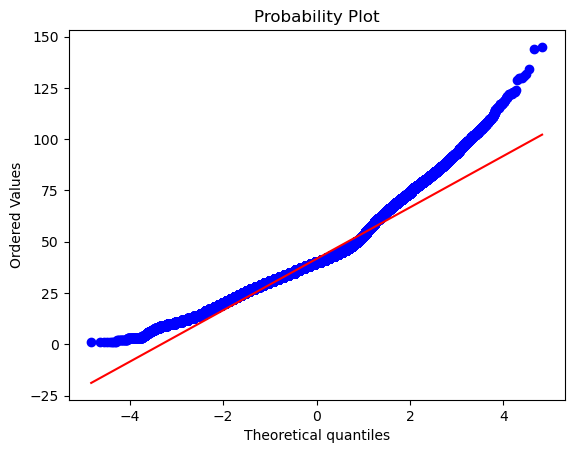

In [24]:
# Check the distribution normality
stats.probplot(uniq_words, plot=plt)

In [26]:
char_corp = x[:1000000][1].apply(len)
char_corp

0
0         325
1         175
2         250
3         292
4         309
         ... 
999995    464
999996    350
999997    346
999998    467
999999    408
Name: 1, Length: 1000000, dtype: int64

Text(0, 0.5, 'Count')

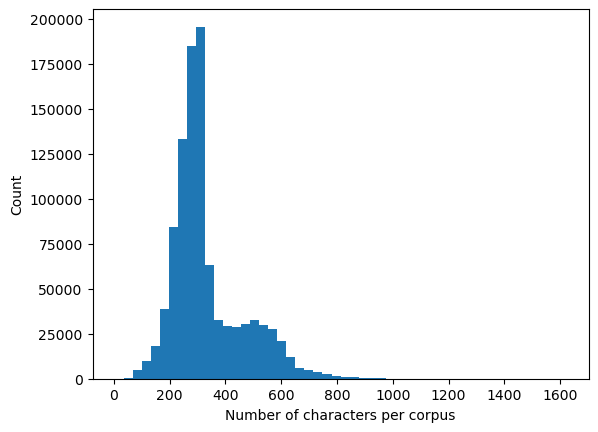

In [27]:
plt.hist(char_corp, bins=50)
plt.xlabel('Number of characters per corpus')
plt.ylabel('Count')

((array([-4.82696512, -4.64718223, -4.54998406, ...,  4.54998406,
          4.64718223,  4.82696512]),
  array([   4,    5,    5, ..., 1266, 1397, 1621])),
 (120.85874343421568, 332.96433699999994, 0.9447820281094406))

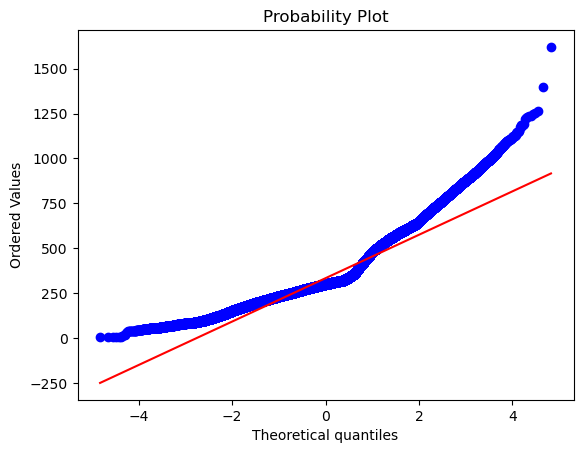

In [28]:
# Check the distribution normality
stats.probplot(char_corp, plot=plt)

In [33]:
counts = pd.DataFrame({'words_per_corpus':words_corp, 'unique_words_per_corpus':uniq_words, "characters_per_corpus":char_corp})

<AxesSubplot:>

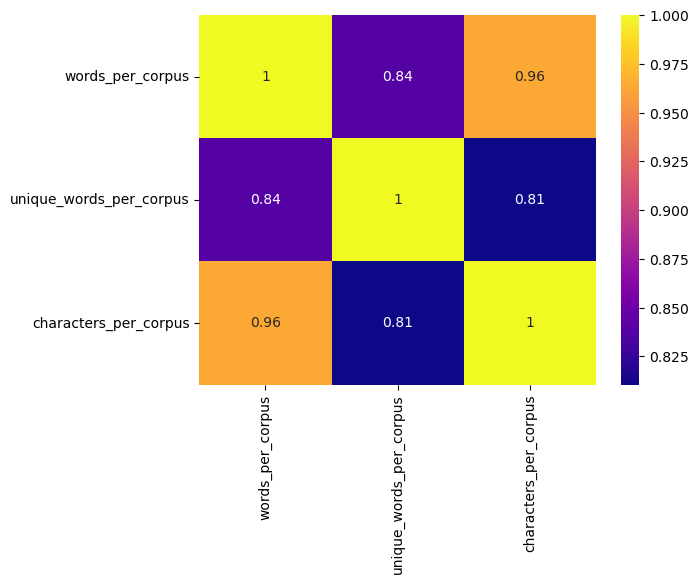

In [34]:
corr= counts.corr()
sns.heatmap(corr,annot=True, cmap= 'plasma')

<AxesSubplot:xlabel='characters_per_corpus', ylabel='words_per_corpus'>

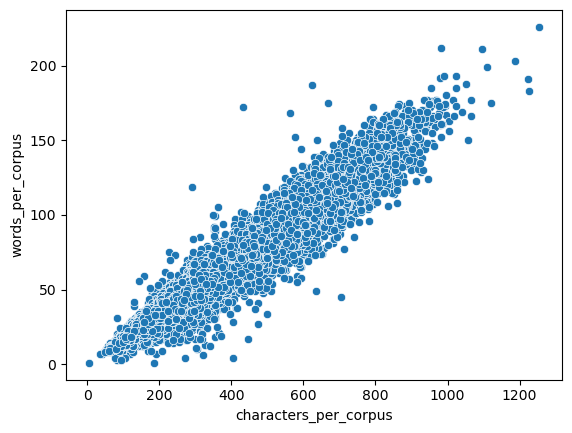

In [35]:
#%%
sns.scatterplot(x='characters_per_corpus', y='words_per_corpus', data = counts)

<AxesSubplot:xlabel='characters_per_corpus', ylabel='unique_words_per_corpus'>

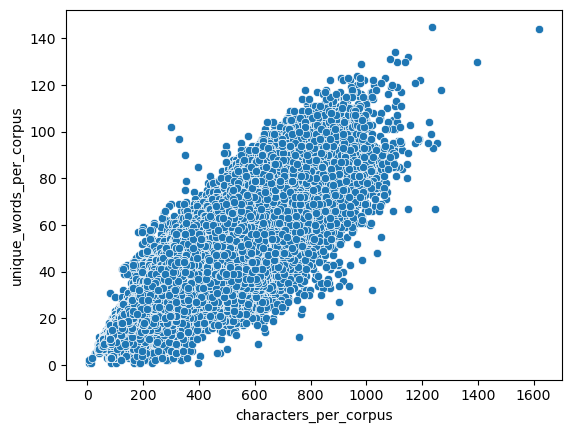

In [36]:
sns.scatterplot(x='characters_per_corpus', y='unique_words_per_corpus', data = counts)

<AxesSubplot:xlabel='words_per_corpus', ylabel='unique_words_per_corpus'>

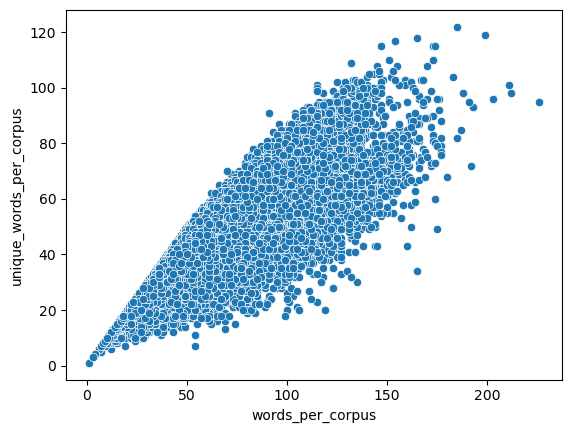

In [37]:
sns.scatterplot(x='words_per_corpus', y='unique_words_per_corpus', data = counts)